In [3]:
import torch 
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn import init
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import time

In [4]:
def my_sigmoid(x):
    return 1/(1+torch.exp(-x))

def my_tanh(x):
    return (torch.exp(x)-torch.exp(-x))/(torch.exp(x)+torch.exp(-x))

def my_relu(x):
    return torch.max(x, torch.zeros_like(x))

def my_gelu(x):
    return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2/np.pi)) * (x + 0.044715 * torch.pow(x, 3))))

In [5]:
class FFN(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens):
        super(FFN, self).__init__()
        self.linear1 = nn.Linear(num_inputs, num_hiddens)
        self.activate = my_relu
        self.linear2 = nn.Linear(num_hiddens, num_outputs)
        # 采用和第一章一样的初始化方法
        init.normal_(self.linear1.weight, mean=0, std=0.01)
        init.normal_(self.linear2.weight, mean=0, std=0.01)
        init.constant_(self.linear1.bias, val=0)
        init.constant_(self.linear2.bias, val=0)
    def forward(self, x):
        x = self.linear1(x)
        x = self.activate(x)
        x = self.linear2(x)
        return x

In [6]:
# 下载MINIST手写数字数据集
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

batch_size = 256
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

for X,y in train_loader:
    print(X.shape, y.shape)
    break

# 定义准确率
def accuracy(y_hat, y):
    return (torch.argmax(y_hat, dim=1) == y).float().mean().item()

torch.Size([256, 1, 28, 28]) torch.Size([256])


In [7]:
# 训练和评估函数
def train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device):
    # 记录训练时间
    start_time = time.time()
    print('Training on: ', device)
    train_loss_list, train_accuracy_list = [], []
    test_loss_list, test_accuracy_list = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_accuracy = 0, 0
        for X, y in train_loader:
            X, y = X.view(-1, 28*28).to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_accuracy += accuracy(pred, y)
        
        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        
        model.eval()
        test_loss, test_accuracy = 0, 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.view(-1, 28*28).to(device), y.to(device)
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                test_accuracy += accuracy(pred, y)
        
        test_loss /= len(test_loader)
        test_accuracy /= len(test_loader)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
        
    print('Training time: ', time.time()-start_time)
    return train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list

# 可视化结果
def show(train_loss_list, test_loss_list, train_accuracy_list=None, test_accuracy_list=None):
    plt.figure(figsize=(12, 5))
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Train Loss')
    plt.plot(test_loss_list, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
     
    if train_accuracy_list != None:
        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracy_list, label='Train Accuracy')
        plt.plot(test_accuracy_list, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy over Epochs')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

Using device: cuda
Training on:  cuda
Epoch [1/60], Train Loss: 2.1413, Train Accuracy: 0.3867, Test Loss: 1.6443, Test Accuracy: 0.6631
Epoch [2/60], Train Loss: 1.0562, Train Accuracy: 0.7606, Test Loss: 0.6867, Test Accuracy: 0.8266
Epoch [3/60], Train Loss: 0.5903, Train Accuracy: 0.8508, Test Loss: 0.4867, Test Accuracy: 0.8728
Epoch [4/60], Train Loss: 0.4649, Train Accuracy: 0.8760, Test Loss: 0.4093, Test Accuracy: 0.8893
Epoch [5/60], Train Loss: 0.4088, Train Accuracy: 0.8881, Test Loss: 0.3689, Test Accuracy: 0.8978
Epoch [6/60], Train Loss: 0.3756, Train Accuracy: 0.8959, Test Loss: 0.3473, Test Accuracy: 0.9038
Epoch [7/60], Train Loss: 0.3537, Train Accuracy: 0.9012, Test Loss: 0.3257, Test Accuracy: 0.9069
Epoch [8/60], Train Loss: 0.3374, Train Accuracy: 0.9050, Test Loss: 0.3140, Test Accuracy: 0.9109
Epoch [9/60], Train Loss: 0.3243, Train Accuracy: 0.9086, Test Loss: 0.3024, Test Accuracy: 0.9132
Epoch [10/60], Train Loss: 0.3132, Train Accuracy: 0.9114, Test Loss: 0

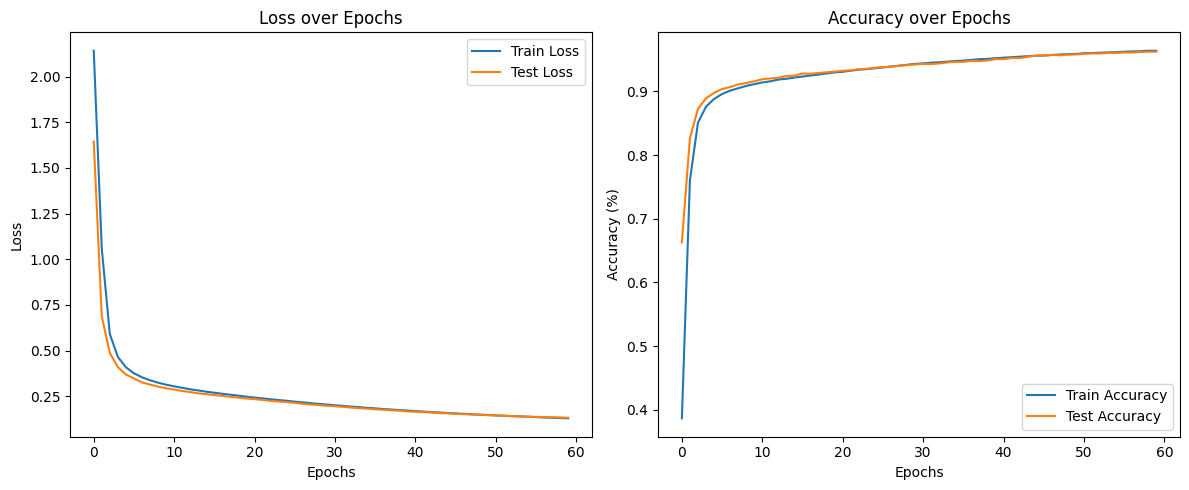

In [8]:
# 定义超参数
lr = 0.03
num_epochs = 60

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:',device)

model = FFN(num_inputs=28*28, num_outputs=10, num_hiddens=64).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_loss_list_relu, train_accuracy_list_relu, test_loss_list_relu, test_accuracy_list_relu = train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device)
show(train_loss_list_relu, test_loss_list_relu, train_accuracy_list_relu, test_accuracy_list_relu)

#### 使用sigmoid激活函数

Using device: cuda
Training on:  cuda
Epoch [1/60], Train Loss: 2.2983, Train Accuracy: 0.1121, Test Loss: 2.2937, Test Accuracy: 0.1138
Epoch [2/60], Train Loss: 2.2795, Train Accuracy: 0.1543, Test Loss: 2.2547, Test Accuracy: 0.2606
Epoch [3/60], Train Loss: 2.1959, Train Accuracy: 0.3213, Test Loss: 2.0985, Test Accuracy: 0.4386
Epoch [4/60], Train Loss: 1.9491, Train Accuracy: 0.4879, Test Loss: 1.7583, Test Accuracy: 0.5580
Epoch [5/60], Train Loss: 1.5918, Train Accuracy: 0.5822, Test Loss: 1.4084, Test Accuracy: 0.6408
Epoch [6/60], Train Loss: 1.2914, Train Accuracy: 0.6616, Test Loss: 1.1564, Test Accuracy: 0.7008
Epoch [7/60], Train Loss: 1.0809, Train Accuracy: 0.7247, Test Loss: 0.9798, Test Accuracy: 0.7577
Epoch [8/60], Train Loss: 0.9303, Train Accuracy: 0.7698, Test Loss: 0.8511, Test Accuracy: 0.7877
Epoch [9/60], Train Loss: 0.8181, Train Accuracy: 0.7982, Test Loss: 0.7530, Test Accuracy: 0.8102
Epoch [10/60], Train Loss: 0.7330, Train Accuracy: 0.8179, Test Loss: 0

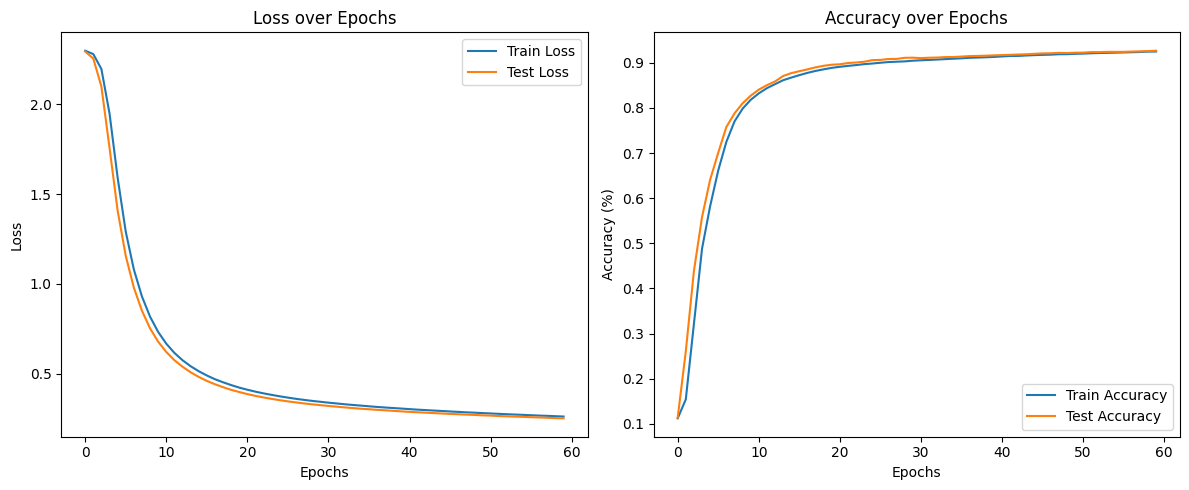

In [9]:
# 定义超参数
lr = 0.03
num_epochs = 60

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:',device)

model = FFN(num_inputs=28*28, num_outputs=10, num_hiddens=64).to(device)
model.activate = my_sigmoid

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_loss_list_sigmoid, train_accuracy_list_sigmoid, test_loss_list_sigmoid, test_accuracy_list_sigmoid = train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device)
show(train_loss_list_sigmoid, test_loss_list_sigmoid, train_accuracy_list_sigmoid, test_accuracy_list_sigmoid)

#### 使用tanh激活函数

Using device: cuda
Training on:  cuda
Epoch [1/60], Train Loss: 2.2979, Train Accuracy: 0.1145, Test Loss: 2.2921, Test Accuracy: 0.1138
Epoch [2/60], Train Loss: 2.2781, Train Accuracy: 0.1583, Test Loss: 2.2524, Test Accuracy: 0.3202
Epoch [3/60], Train Loss: 2.1898, Train Accuracy: 0.3446, Test Loss: 2.0889, Test Accuracy: 0.4131
Epoch [4/60], Train Loss: 1.9352, Train Accuracy: 0.4964, Test Loss: 1.7387, Test Accuracy: 0.5694
Epoch [5/60], Train Loss: 1.5671, Train Accuracy: 0.5980, Test Loss: 1.3786, Test Accuracy: 0.6339
Epoch [6/60], Train Loss: 1.2630, Train Accuracy: 0.6701, Test Loss: 1.1283, Test Accuracy: 0.7047
Epoch [7/60], Train Loss: 1.0595, Train Accuracy: 0.7278, Test Loss: 0.9618, Test Accuracy: 0.7481
Epoch [8/60], Train Loss: 0.9182, Train Accuracy: 0.7687, Test Loss: 0.8424, Test Accuracy: 0.7851
Epoch [9/60], Train Loss: 0.8145, Train Accuracy: 0.7964, Test Loss: 0.7524, Test Accuracy: 0.8116
Epoch [10/60], Train Loss: 0.7345, Train Accuracy: 0.8166, Test Loss: 0

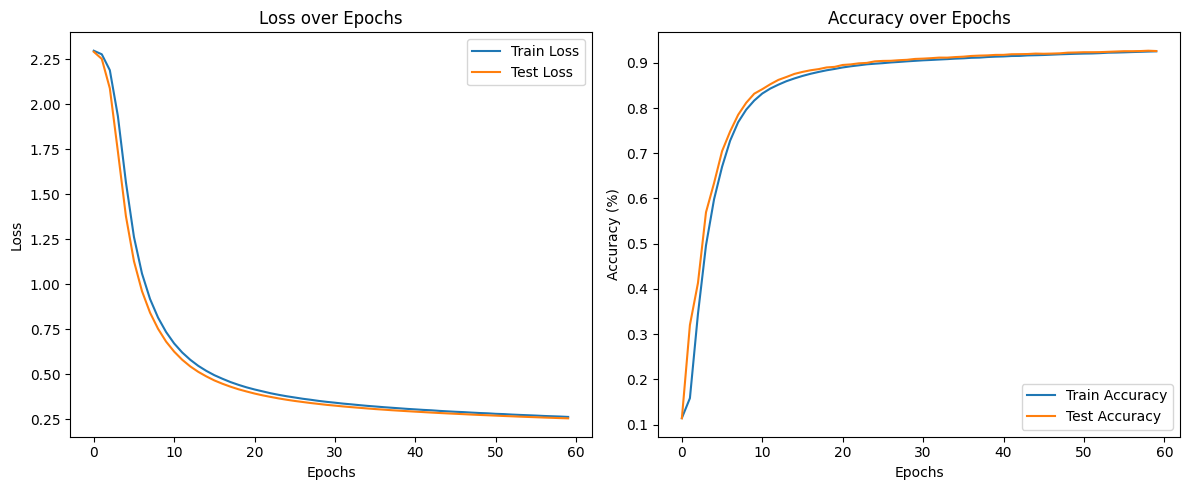

In [10]:
# 定义超参数
lr = 0.03
num_epochs = 60

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:',device)

model = FFN(num_inputs=28*28, num_outputs=10, num_hiddens=64).to(device)
model.activate = my_sigmoid

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_loss_list_tanh, train_accuracy_list_tanh, test_loss_list_tanh, test_accuracy_list_tanh = train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device)
show(train_loss_list_tanh, test_loss_list_tanh, train_accuracy_list_tanh, test_accuracy_list_tanh)

#### 使用GELU激活函数

Using device: cuda
Training on:  cuda
Epoch [1/60], Train Loss: 2.2593, Train Accuracy: 0.3155, Test Loss: 2.1014, Test Accuracy: 0.3927
Epoch [2/60], Train Loss: 1.4356, Train Accuracy: 0.6561, Test Loss: 0.8234, Test Accuracy: 0.7932
Epoch [3/60], Train Loss: 0.6598, Train Accuracy: 0.8318, Test Loss: 0.5231, Test Accuracy: 0.8613
Epoch [4/60], Train Loss: 0.4881, Train Accuracy: 0.8698, Test Loss: 0.4238, Test Accuracy: 0.8865
Epoch [5/60], Train Loss: 0.4189, Train Accuracy: 0.8854, Test Loss: 0.3760, Test Accuracy: 0.8953
Epoch [6/60], Train Loss: 0.3817, Train Accuracy: 0.8937, Test Loss: 0.3480, Test Accuracy: 0.9046
Epoch [7/60], Train Loss: 0.3576, Train Accuracy: 0.8996, Test Loss: 0.3279, Test Accuracy: 0.9077
Epoch [8/60], Train Loss: 0.3394, Train Accuracy: 0.9045, Test Loss: 0.3150, Test Accuracy: 0.9091
Epoch [9/60], Train Loss: 0.3263, Train Accuracy: 0.9076, Test Loss: 0.3019, Test Accuracy: 0.9146
Epoch [10/60], Train Loss: 0.3147, Train Accuracy: 0.9102, Test Loss: 0

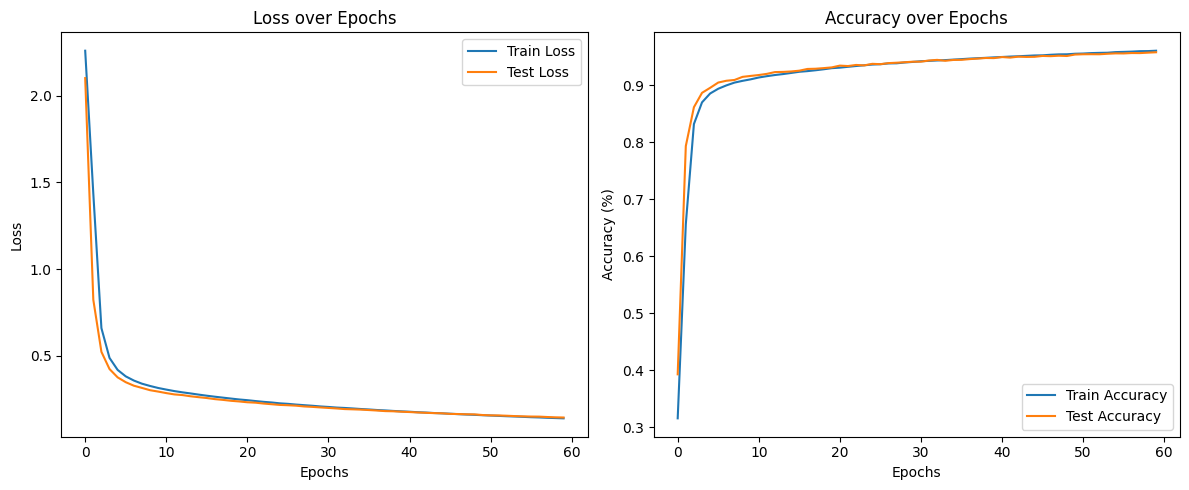

In [11]:
# 定义超参数
lr = 0.03
num_epochs = 60

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:',device)

model = FFN(num_inputs=28*28, num_outputs=10, num_hiddens=64).to(device)
model.activate = nn.GELU()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_loss_list_gelu, train_accuracy_list_gelu, test_loss_list_gelu, test_accuracy_list_gelu = train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device)
show(train_loss_list_gelu, test_loss_list_gelu, train_accuracy_list_gelu, test_accuracy_list_gelu)

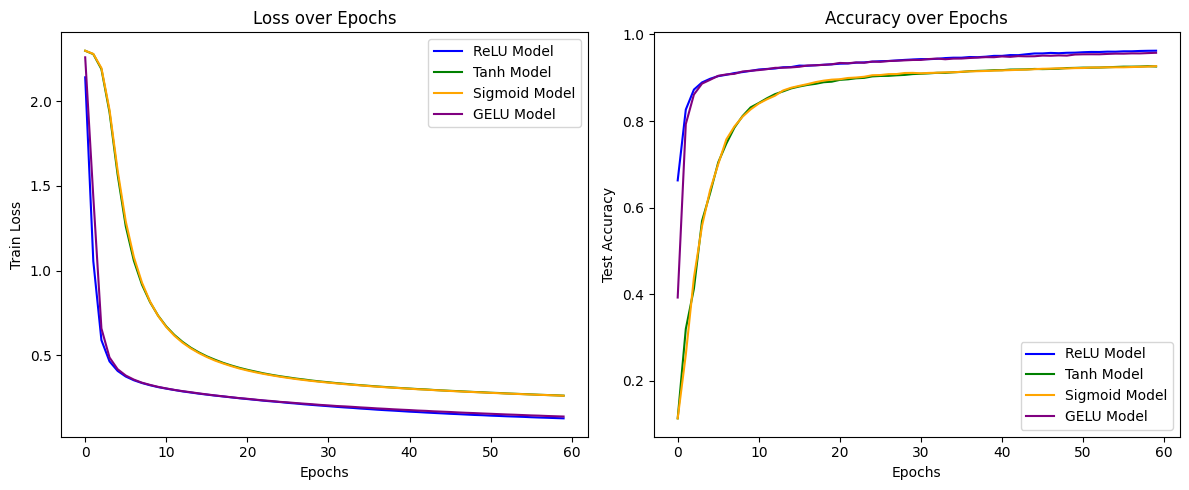

In [12]:
# 可视化结果
def show_all(train_loss_list_relu, train_loss_list_tanh, train_loss_list_sigmoid, train_loss_list_gelu, test_acc_list_relu, test_acc_list_tanh, test_acc_list_sigmoid, test_acc_list_gelu):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list_relu, label='ReLU Model', color='blue')
    plt.plot(train_loss_list_tanh, label='Tanh Model', color='green')
    plt.plot(train_loss_list_sigmoid, label='Sigmoid Model', color='orange')
    plt.plot(train_loss_list_gelu, label='GELU Model', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('Train Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_acc_list_relu, label='ReLU Model', color='blue')
    plt.plot(test_acc_list_tanh, label='Tanh Model', color='green')
    plt.plot(test_acc_list_sigmoid, label='Sigmoid Model', color='orange')
    plt.plot(test_acc_list_gelu, label='GELU Model', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('Test Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
show_all(train_loss_list_relu, train_loss_list_tanh, train_loss_list_sigmoid, train_loss_list_gelu, test_accuracy_list_relu, test_accuracy_list_tanh, test_accuracy_list_sigmoid, test_accuracy_list_gelu)